In [41]:
import numpy as np
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from latex import set_size

plt.style.use("tex")
sns.set_palette("colorblind")

datadir = "../data/"
figdir = "../figures/"

beta = 1.66e-11
R = np.sqrt(9.81*4000)/1e-4

In [42]:
def find_maximums(da, intervals):
    maximums = []
    for interval in intervals:
        da_sel = da.sel(time=slice(interval[0], interval[1]))
        maximum = da_sel.where(da_sel==da_sel.max(), drop=True).squeeze()
        maximums.append(maximum)
    return maximums

def find_maximums_alt(da, intervals):
    da_i = da.sel(x=0, method="nearest")
    da_f = da.sel(x=slice(-0.5e6, 0.5e6))
    da_sel_i = da_i.sel(time=slice(intervals[0][0], intervals[0][1]))
    maximum_i = da_sel_i.where(da_sel_i==da_sel_i.max(), drop=True).squeeze()
    
    da_sel_f = da_f.sel(time=slice(intervals[1][0], intervals[1][1]))
    da_sel_f = da_sel_f.sel(x=da.x.min(), method="nearest")
    maximum_f = da_sel_f.where(da_sel_f==da_sel_f.max(), drop=True).squeeze()
    
    return [maximum_i, maximum_f]

def find_extrema(da):
    da_sel = da.sel(time=slice(1, 150))
    maximum = da_sel.where(da_sel==da_sel.max(), drop=True).squeeze()
    minimum = da_sel.where(da_sel==da_sel.min(), drop=True).squeeze()
    return minimum, maximum

def slope(x1, x2):
    return (x1.x - x2.x)/(x1.time - x2.time)

def compute_k(Lw):
    k=(1.3*np.pi/Lw)/np.sqrt(5)
    return k

def compute_Lw(Lw):
    return np.sqrt(9.81*4000)/1e-4*Lw

def analytical_group_velocity(U, k):
    beta = 1.66e-11
    R2 = 9.81*4000/1e-4**2
    return U + beta*(k**2 - 1/R2)/(k**2 + 1/R2)**2

def analytical_phase_velocity(k):
    beta = 1.66e-11
    R2 = 9.81*4000/1e-4**2
    return -beta/(k**2 + 1/R2)

In [43]:
names = ["0","1", "4", "9", "14"]
datasets = []
for i in range(len(names)):
    names[i] = "h_U" + names[i]
    ds = xr.open_dataset(datadir + names[i] + ".nc")
    ds = ds.rename(h=names[i])
    datasets.append(ds)
ds = xr.merge(datasets)
ds

<xarray.Dataset>
Dimensions:  (time: 121, x: 300, y: 300)
Coordinates:
  * x        (x) float64 -1.395e+07 -1.386e+07 ... 1.386e+07 1.395e+07
  * y        (y) float64 -8.143e+06 -8.097e+06 -8.05e+06 ... 5.763e+06 5.81e+06
  * time     (time) float64 0.0 6.0 12.0 18.0 24.0 ... 702.0 708.0 714.0 720.0
Data variables:
    h_U0     (time, y, x) float32 ...
    h_U1     (time, y, x) float32 ...
    h_U4     (time, y, x) float32 ...
    h_U9     (time, y, x) float32 ...
    h_U14    (time, y, x) float32 ...

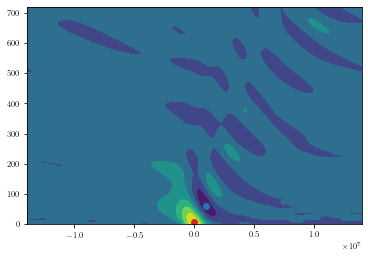

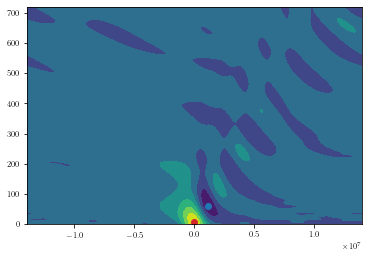

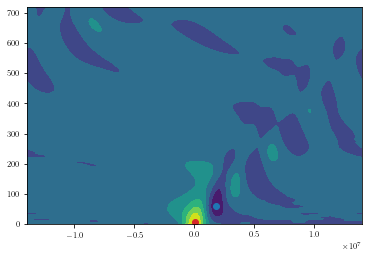

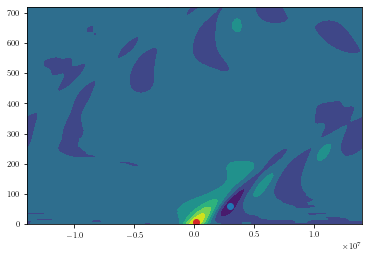

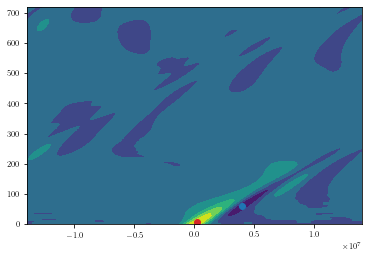

In [49]:
ds_eq = ds.sel(y=0, method="nearest")

group_velocities = []
for name in names:
    minimum, maximum = find_extrema(ds_eq[name])
    group_velocities.append(float(slope(minimum, maximum).values)/60/60)
    fig, ax = plt.subplots(1, 1)
    ax.contourf(ds_eq.x, ds_eq.time, ds_eq[name])
    ax.plot(minimum.x, minimum.time, "o", color="tab:blue")
    ax.plot(maximum.x, maximum.time, "o", color="tab:red")

[1.0015116  5.24201559]


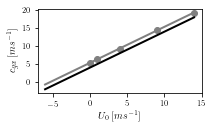

In [68]:
fig, ax = plt.subplots(1, 1, figsize=set_size(width=221))

meanflows = np.array([0, 1, 4, 9, 14])

meanflows_a = np.linspace(meanflows[0]-6, meanflows[-1], 100)

coeff = np.polyfit(meanflows, group_velocities, 1)
print(coeff)
p = np.poly1d(coeff)


ax.scatter(meanvelocities, group_velocities,
          color="grey")
ax.plot(meanflows_a, analytical_group_velocity(meanflows_a, compute_k(compute_Lw(0.5))),
        color="black",
        linewidth=2
       )
ax.plot(meanflows_a, p(meanflows_a),
        color="grey",
        linewidth=2
       )
ax.set_xlabel(r"$U_0 \, [ms^{-1}]$")
ax.set_ylabel(r"$c_{gx} \, [ms^{-1}]$")

fig.tight_layout()
fig.savefig(figdir + "group_velocities.pdf", dpi=600, bbox_inches="tight")